# Assignment Question: Bayesian Analysis of 50-yard Swim Times

Download the CSV file swim_time.csv from Canvas. The data file contains a data matrix on the amount of time, in seconds, it takes each of four high school swimmers to swim 50 yards. Each swimmer has six times, taken on a biweekly basis.

## Questions

**(a)** For each swimmer j (j = 1, 2, 3, 4), fit a Bayesian linear regression model where considers the swimming time as the response variable and week as the explanatory variable. To formulate your prior, use the information that competitive times for this age group generally range from 22 to 24 seconds.

**(b)** For each swimmer j (j = 1, 2, 3, 4), obtain a posterior predictive distribution for Y*_j, their time if they were to swim two weeks from the last recorded time.

**(c)** The coach of the team has to decide which of the four swimmers will compete in a swimming meet in two weeks. Using your predictive distributions, compute Pr(Y*_j = min{Y*_1, ..., Y*_4} |Y) for each swimmer j, and based on this make a recommendation to the coach.

---

This notebook fits a Bayesian linear regression for each swimmer and produces posterior predictive distributions two weeks beyond the last observation (Week 13).

The workflow is PEP 8 friendly, type hinted, and organized to the best of my abilities so that plots for analysis appear before conclusions.


In [1]:
%pip install pymc arviz seaborn

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Iterable, List, Tuple

import warnings

# Suppress ipywidgets warning from rich library (set before PyMC import)
warnings.filterwarnings("ignore", message=".*install.*ipywidgets.*", category=UserWarning)

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Global plotting style - clean and professional
sns.set_theme(style="whitegrid", context="talk", palette="husl")
plt.rcParams.update({
    "figure.autolayout": True,
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans", "Helvetica", "sans-serif"]
})

# Reproducibility
RNG_SEED: int = 2025
rng: np.random.Generator = np.random.default_rng(RNG_SEED)

pd.options.display.float_format = "{:0.3f}".format


Note: you may need to restart the kernel to use updated packages.


In [2]:
def load_data(path: str) -> pd.DataFrame:
    """Load the swim time data in wide format.

    Parameters
    ----------
    path : str
        Path to the CSV file.

    Returns
    -------
    pd.DataFrame
        Wide-form data frame with swimmers in rows and weeks in columns.
    """
    wide = pd.read_csv(path).rename(columns={"Unnamed: 0": "Swimmer"})
    wide["Swimmer"] = wide["Swimmer"].astype(str)
    return wide


def tidy_data(wide: pd.DataFrame) -> pd.DataFrame:
    """Convert wide data to tidy long format with numeric week variable.

    The melted label column is renamed to 'WeekLabel' to avoid
    a collision with the numeric column 'week_num'.

    Parameters
    ----------
    wide : pd.DataFrame
        Wide-form data frame.

    Returns
    -------
    pd.DataFrame
        Long-form data with columns: Swimmer, WeekLabel, Time_sec, week_num.
    """
    long = (
        wide.melt(id_vars="Swimmer", var_name="WeekLabel",
                  value_name="Time_sec")
        .assign(week_num=lambda d: d["WeekLabel"].str.extract(r"(\d+)")
                .astype(int))
        .sort_values(["Swimmer", "week_num"]) 
        .reset_index(drop=True)
    )
    return long


def week_star_from(long: pd.DataFrame, offset: int = 2) -> int:
    """Compute future week for prediction.

    Parameters
    ----------
    long : pd.DataFrame
        Tidy data with numeric week variable.
    offset : int
        Weeks to project ahead.

    Returns
    -------
    int
        Future week number for prediction.
    """
    weeks = np.sort(long["week_num"].unique())
    return int(weeks.max() + offset)


In [3]:
def summarize_by_swimmer(long: pd.DataFrame) -> pd.DataFrame:
    """Return basic summary stats per swimmer."""
    summ = (
        long.groupby("Swimmer")["Time_sec"]
        .agg(["count", "mean", "std", "min", "max"])
        .reset_index()
        .sort_values("Swimmer")
    )
    return summ


def plot_eda(long: pd.DataFrame) -> None:
    """Exploratory scatter and line plots using seaborn."""
    g = sns.FacetGrid(
        long, col="Swimmer", col_wrap=2, height=4, sharey=False, sharex=True
    )
    g.map_dataframe(sns.scatterplot, x="week_num", y="Time_sec", s=60)
    g.map_dataframe(sns.lineplot, x="week_num", y="Time_sec", estimator=None)
    g.set_axis_labels("Week", "Time (sec)")
    g.set_titles("{col_name}")
    plt.suptitle("Observed times by week", y=1.03)
    plt.show()


def plot_pair(long: pd.DataFrame) -> None:
    """Pairwise relationships using unique numeric 'week_num'."""
    data = (
        long[["week_num", "Time_sec", "Swimmer"]]
        .rename(columns={"week_num": "Week", "Time_sec": "Time"})
    )
    sns.pairplot(
        data, vars=["Week", "Time"], hue="Swimmer",
        corner=True, diag_kind="kde"
    )
    plt.suptitle("Quick pairwise view", y=1.03)
    plt.show()


## Priors and prior predictive checks

Model and priors (per swimmer j):
```
y_ij ~ Normal(alpha_j + beta_j * x_ij, sigma_j^2)
alpha_j ~ Normal(23, 1^2)
beta_j  ~ Normal(0, 0.2^2)
sigma_j ~ HalfNormal(0.5)
```
The priors reflect competitive times near 22-24 s and modest slopes.


In [4]:
def prior_predictive_spaghetti(
    weeks: np.ndarray,
    n_sims: int = 400,
    seed: int = 2025
) -> None:
    """Plot prior predictive spaghetti across the observed weeks."""
    rng_loc = np.random.default_rng(seed)
    x_vals = weeks.astype(float)

    alpha_sim = rng_loc.normal(23.0, 1.0, size=n_sims)
    beta_sim = rng_loc.normal(0.0, 0.2, size=n_sims)
    sigma_sim = np.abs(rng_loc.normal(0.0, 0.5, size=n_sims))

    fig, ax = plt.subplots(figsize=(10, 6))
    for i in range(n_sims):
        mu = alpha_sim[i] + beta_sim[i] * x_vals
        ysim = rng_loc.normal(mu, sigma_sim[i])
        sns.lineplot(x=x_vals, y=ysim, alpha=0.08, linewidth=1, color="steelblue", ax=ax)
    ax.axhline(22.0, linestyle="--", color="red", linewidth=1.5, label="22s")
    ax.axhline(24.0, linestyle="--", color="red", linewidth=1.5, label="24s")
    ax.set_title("Prior predictive spaghetti by week", fontsize=14, pad=10)
    ax.set_xlabel("Week", fontsize=12)
    ax.set_ylabel("Time (sec)", fontsize=12)
    ax.legend()
    plt.tight_layout()
    plt.show()


## Answer to Question (a): Fit Bayesian linear regression for each swimmer

For each swimmer j (j = 1, 2, 3, 4), we fit a Bayesian linear regression model where the swimming time is the response variable and week is the explanatory variable. The prior is formulated using the information that competitive times for this age group generally range from 22 to 24 seconds.


In [5]:
@dataclass
class FitResult:
    """Container for model fit results and future predictions."""
    idata: az.InferenceData  # Posterior inference data
    y_star: np.ndarray  # Posterior predictive draws for future week


def fit_swimmer_pymc(
    swimmer_data: pd.DataFrame,
    future_week: float,
    draws: int = 2000,
    tune: int = 2000,
    seed: int = 2025
) -> FitResult:
    """
    Fit PyMC linear model for one swimmer and predict at future week.
    
    Parameters
    ----------
    swimmer_data : pd.DataFrame
        Data for a single swimmer with columns 'week_num' and 'Time_sec'.
    future_week : float
        Week number for future prediction (e.g., Week 13).
    draws : int
        Number of posterior draws per chain.
    tune : int
        Number of tuning iterations per chain.
    seed : int
        Random seed for reproducibility.
    
    Returns
    -------
    FitResult
        Object containing posterior inference data and future predictions.
    """
    # Extract week numbers and swim times
    x = swimmer_data["week_num"].to_numpy(dtype=float)
    y = swimmer_data["Time_sec"].to_numpy(dtype=float)

    with pm.Model() as model:
        # Priors: competitive times range 22-24 seconds, small slope expected
        alpha = pm.Normal("alpha", mu=23.0, sigma=1.0)  # Intercept (mean time)
        beta = pm.Normal("beta", mu=0.0, sigma=0.2)  # Slope (change per week)
        sigma = pm.HalfNormal("sigma", sigma=0.5)  # Residual standard deviation

        # Linear model: time = alpha + beta * week
        mu = alpha + beta * x
        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample posterior distribution
        idata = pm.sample(
            draws=draws,
            tune=tune,
            target_accept=0.99,
            chains=4,
            random_seed=seed,
            progressbar=True,
        )

        # Posterior predictive distribution for future week
        mu_future = idata.posterior["alpha"] + idata.posterior["beta"] * future_week
        sigma_post = idata.posterior["sigma"]
        mu_future_np = np.array(mu_future).reshape(-1)
        sigma_np = np.array(sigma_post).reshape(-1)

        # Generate posterior predictive draws
        rng_loc = np.random.default_rng(seed)
        future_time_predictions = rng_loc.normal(loc=mu_future_np, scale=sigma_np)

    return FitResult(idata=idata, y_star=future_time_predictions)


def fit_all_swimmers(
    long: pd.DataFrame,
    future_week: float,
    draws: int = 2000,
    tune: int = 2000
) -> Tuple[Dict[str, az.InferenceData], Dict[str, np.ndarray]]:
    """
    Fit models for all swimmers and collect predictions at future week.
    
    Parameters
    ----------
    long : pd.DataFrame
        Long-format data with all swimmers.
    future_week : float
        Week number for future prediction.
    draws : int
        Number of posterior draws per chain.
    tune : int
        Number of tuning iterations per chain.
    
    Returns
    -------
    Tuple[Dict[str, az.InferenceData], Dict[str, np.ndarray]]
        Dictionary of inference data and predictions for each swimmer.
    """
    traces: Dict[str, az.InferenceData] = {}
    preds: Dict[str, np.ndarray] = {}
    # Fit model for each swimmer separately
    for swimmer, swimmer_group in long.groupby("Swimmer"):
        res = fit_swimmer_pymc(
            swimmer_data=swimmer_group,
            future_week=future_week,
            draws=draws,
            tune=tune,
            seed=hash(swimmer) % (2**32),  # Deterministic seed per swimmer
        )
        traces[swimmer] = res.idata
        preds[swimmer] = res.y_star
    return traces, preds


In [6]:
def az_diagnostics(traces: Dict[str, az.InferenceData]) -> pd.DataFrame:
    """Compute ArviZ summary diagnostics per swimmer."""
    rows: List[pd.DataFrame] = []
    for swimmer, idata in traces.items():
        summ = az.summary(idata, var_names=["alpha", "beta", "sigma"]).copy()
        summ.insert(0, "Swimmer", swimmer)
        rows.append(summ.reset_index().rename(columns={"index": "Param"}))
    out = pd.concat(rows, ignore_index=True)
    return out


def plot_traces(traces: Dict[str, az.InferenceData]) -> None:
    """Trace plots for each swimmer."""
    for swimmer, idata in traces.items():
        az.plot_trace(idata, var_names=["alpha", "beta", "sigma"])
        plt.suptitle(f"Trace plots: {swimmer}", y=1.02)
        plt.show()


def plot_autocorr(traces: Dict[str, az.InferenceData]) -> None:
    """Autocorrelation plots for each swimmer."""
    for swimmer, idata in traces.items():
        az.plot_autocorr(idata, var_names=["alpha", "beta", "sigma"])
        plt.suptitle(f"Autocorrelation: {swimmer}", y=1.02)
        plt.show()


In [7]:
def predictive_checks(
    long: pd.DataFrame, traces: Dict[str, az.InferenceData]
) -> None:
    """Posterior predictive checks by swimmer and week."""
    # Iterate over each swimmer's data
    for swimmer, swimmer_group in long.groupby("Swimmer"):
        x = swimmer_group["week_num"].to_numpy(dtype=float)
        y = swimmer_group["Time_sec"].to_numpy(dtype=float)
        idata = traces[swimmer]
        alpha = np.array(idata.posterior["alpha"]).reshape(-1)
        beta = np.array(idata.posterior["beta"]).reshape(-1)
        sigma = np.array(idata.posterior["sigma"]).reshape(-1)

        fig, ax = plt.subplots(figsize=(10, 6))
        colors = sns.color_palette("husl", len(x))
        for idx, (xi, yi) in enumerate(zip(x, y)):
            mu = alpha + beta * xi
            yrep = rng.normal(mu, sigma, size=len(mu))
            sns.kdeplot(yrep, fill=True, alpha=0.25, linewidth=2, color=colors[idx], ax=ax, label=f"Week {int(xi)}")
            ax.axvline(yi, linestyle="--", color=colors[idx], linewidth=1.5, alpha=0.7)
        ax.set_title(f"Posterior predictive checks: {swimmer}", fontsize=14, pad=10)
        ax.set_xlabel("Time (sec)", fontsize=12)
        ax.set_ylabel("Density", fontsize=12)
        ax.legend(fontsize=9)
        plt.tight_layout()
        plt.show()


## Answer to Question (b): Posterior predictive distribution for Week 13

For each swimmer j (j = 1, 2, 3, 4), we obtain a posterior predictive distribution for Y*_j, their time if they were to swim two weeks from the last recorded time (Week 13).


In [8]:
def align_draws(preds: Dict[str, np.ndarray]) -> Tuple[np.ndarray, List[str]]:
    """Stack predictive draws into a matrix with equal sample counts."""
    swimmers = sorted(preds.keys())
    min_n = min(len(v) for v in preds.values())
    stack = np.vstack([preds[k][:min_n] for k in swimmers])
    return stack, swimmers


def prob_best(stack: np.ndarray) -> np.ndarray:
    """Estimate P(best) by Monte Carlo, counting ties for all ties."""
    mins = stack.min(axis=0)
    is_min = (stack == mins)
    return is_min.mean(axis=1)


def predictive_summaries(
    stack: np.ndarray, swimmers: Iterable[str]
) -> pd.DataFrame:
    """Summaries of posterior predictive for each swimmer."""
    rows: List[dict] = []
    for i, s in enumerate(swimmers):
        draws = stack[i]
        rows.append(
            {
                "Swimmer": s,
                "Pred mean (sec)": float(np.mean(draws)),
                "Pred sd (sec)": float(np.std(draws, ddof=1)),
                "Pred 95% CrI low": float(np.percentile(draws, 2.5)),
                "Pred 95% CrI high": float(np.percentile(draws, 97.5)),
            }
        )
    return pd.DataFrame(rows).sort_values("Swimmer")


## Answer to Question (c): Probability of being best and recommendation

The coach needs to decide which of the four swimmers will compete in a swimming meet in two weeks. Using the predictive distributions, we compute Pr(Y*_j = min{Y*_1, ..., Y*_4} |Y) for each swimmer j, and make a recommendation to the coach.


In [9]:
def plot_week13_predictives(
    stack: np.ndarray, swimmers: List[str], week_star: int
) -> None:
    """Histogram and KDE for Week-13 predictives per swimmer."""
    n = len(swimmers)
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))
    axes = axes.ravel()

    for i, s in enumerate(swimmers):
        ax = axes[i]
        sns.histplot(stack[i], bins=30, stat="density", ax=ax, alpha=0.5)
        sns.kdeplot(stack[i], ax=ax, linewidth=2)
        ax.set_title(f"{s}: Week {week_star} predictive")
        ax.set_xlabel("Time (sec)")
        ax.set_ylabel("Density")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Posterior predictive for Week 13", y=1.02)
    plt.show()


def plot_prob_best(
    swimmers: List[str], p_best: np.ndarray, week_star: int
) -> None:
    """Bar plot of P(best) per swimmer."""
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=swimmers, y=p_best, hue=swimmers, palette="husl", ax=ax, edgecolor="white", linewidth=1.5, legend=False)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel("Swimmer", fontsize=12)
    ax.set_ylabel("Probability", fontsize=12)
    ax.set_title(f"P(best) at Week {week_star}", fontsize=14, pad=10)
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [10]:
def main() -> None:
    """Run the full analysis with plots before conclusions."""
    path = "../data/swim_time.csv"
    wide = load_data(path)
    long = tidy_data(wide)
    wk_star = week_star_from(long, offset=2)

    # EDA
    display(summarize_by_swimmer(long))
    plot_eda(long)
    plot_pair(long)

    # Prior predictive
    weeks = np.sort(long["week_num"].unique())
    prior_predictive_spaghetti(weeks, n_sims=400, seed=RNG_SEED)

    # Fit models
    # Fit models for all swimmers and generate predictions for future week
    traces, preds = fit_all_swimmers(long, future_week=float(wk_star),
                                     draws=2000, tune=2000)

    # Diagnostics and PPC before conclusions
    diag = az_diagnostics(traces)
    display(diag)
    plot_traces(traces)
    plot_autocorr(traces)
    predictive_checks(long, traces)

    # Week-13 predictions
    stack, swimmers = align_draws(preds)
    p_best = prob_best(stack)
    plot_week13_predictives(stack, swimmers, wk_star)
    plot_prob_best(swimmers, p_best, wk_star)

    # Summaries and recommendation
    pred_summ = predictive_summaries(stack, swimmers)
    display(pred_summ)

    best_idx = int(np.argmax(p_best))
    best_swimmer = swimmers[best_idx]
    print("Recommendation for the meet in two weeks:", best_swimmer)


,Swimmer,count,mean,std,min,max
0,Swimmer 1,6,22.933,0.186,22.700,23.200
1,Swimmer 2,6,23.350,0.164,23.100,23.500
2,Swimmer 3,6,22.767,0.103,22.600,22.900
3,Swimmer 4,6,23.567,0.121,23.400,23.700


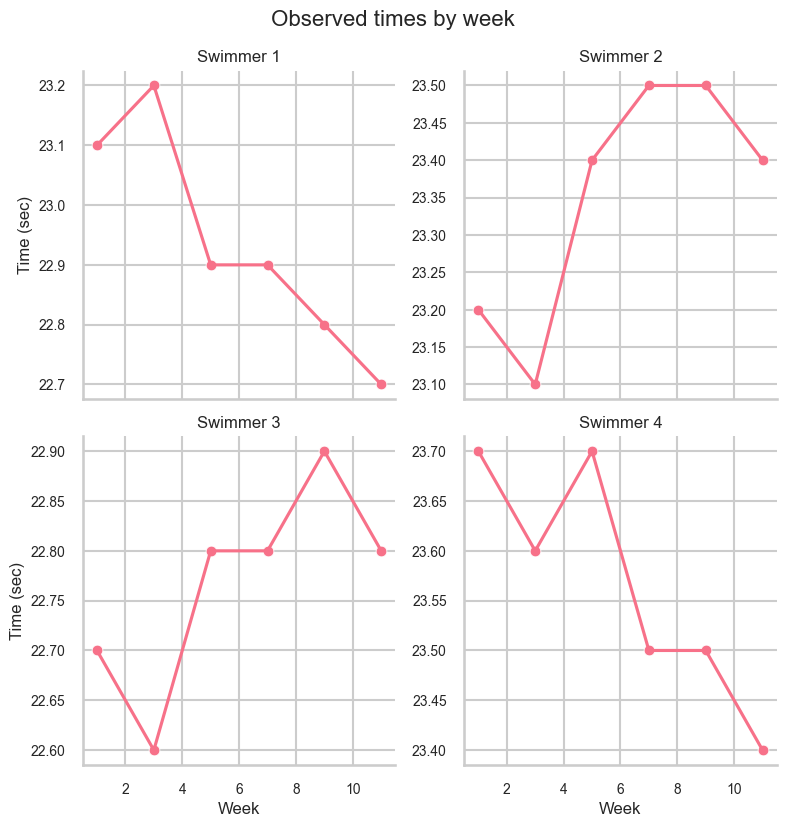

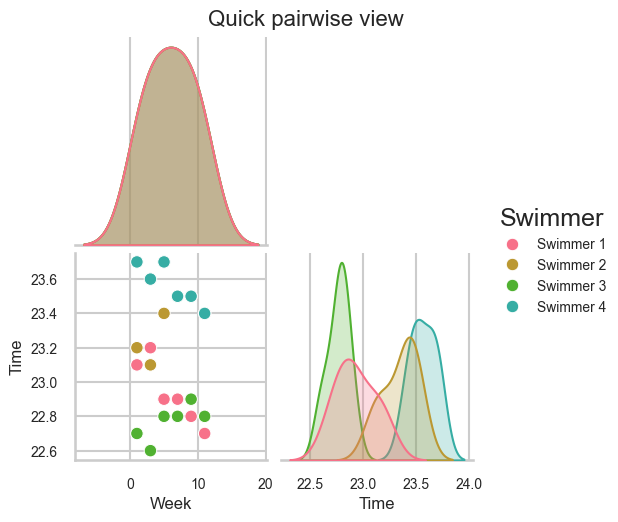

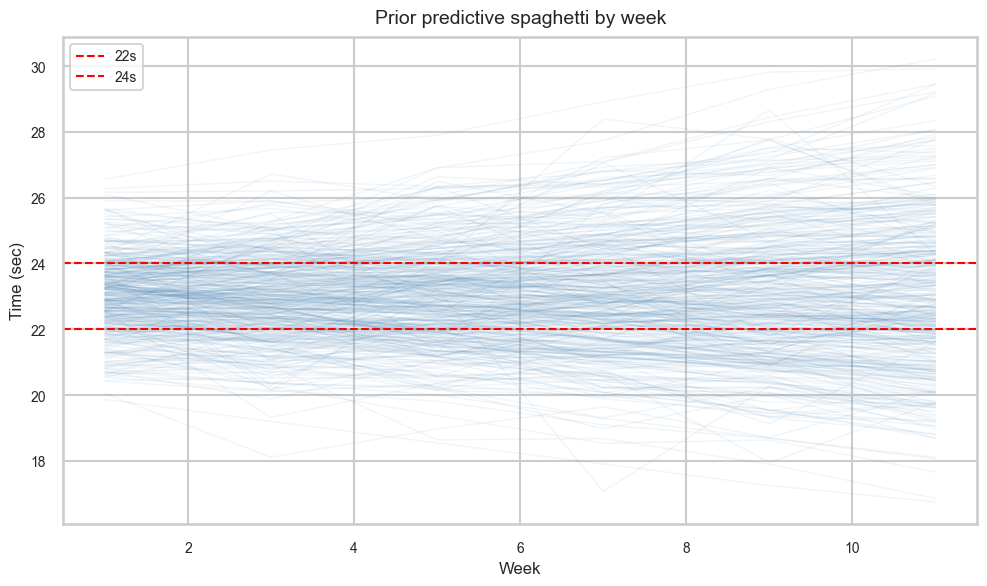

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, beta, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, beta, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, beta, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, beta, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


,Param,Swimmer,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,alpha,Swimmer 1,23.202,0.108,23.005,23.407,0.003,0.003,1923.000,1938.000,1.000
1,beta,Swimmer 1,-0.045,0.016,-0.074,-0.017,0.000,0.001,1769.000,1743.000,1.000
2,sigma,Swimmer 1,0.120,0.064,0.047,0.230,0.002,0.002,1651.000,2312.000,1.000
3,alpha,Swimmer 2,23.148,0.157,22.836,23.430,0.004,0.006,1851.000,1382.000,1.000
4,beta,Swimmer 2,0.033,0.023,-0.009,0.077,0.001,0.001,1802.000,1497.000,1.000
5,sigma,Swimmer 2,0.177,0.089,0.066,0.332,0.002,0.003,1854.000,2366.000,1.000
6,alpha,Swimmer 3,22.658,0.116,22.453,22.877,0.003,0.006,1778.000,1688.000,1.000
7,beta,Swimmer 3,0.018,0.016,-0.014,0.048,0.000,0.001,1777.000,1685.000,1.000
8,sigma,Swimmer 3,0.119,0.069,0.042,0.231,0.002,0.004,1463.000,2109.000,1.000
9,alpha,Swimmer 4,23.730,0.090,23.572,23.900,0.002,0.005,1753.000,1807.000,1.000


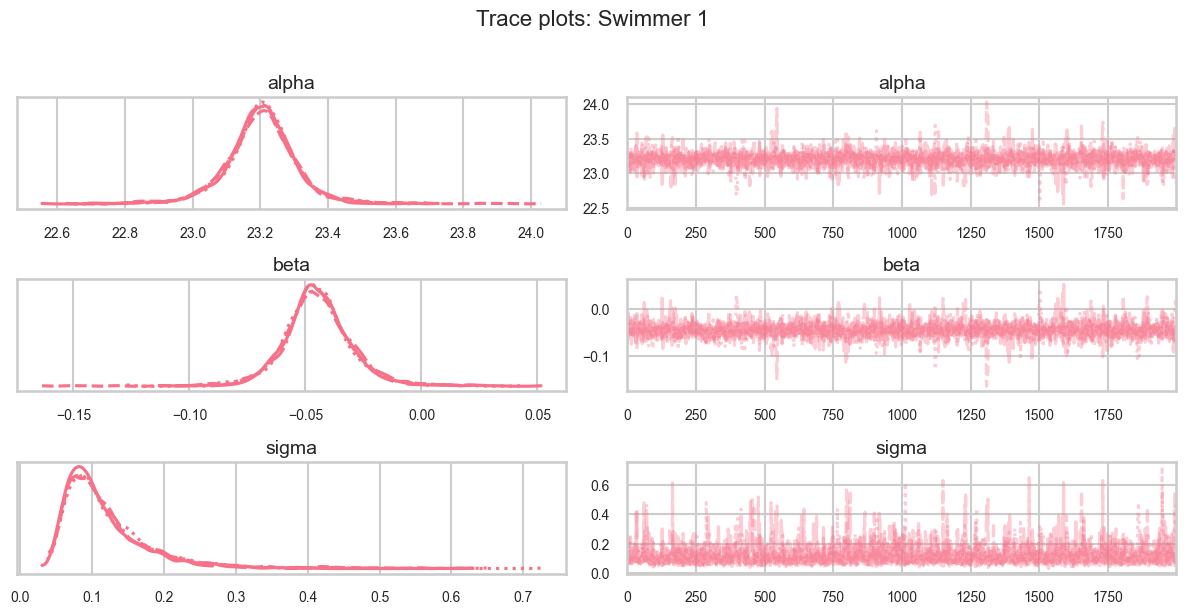

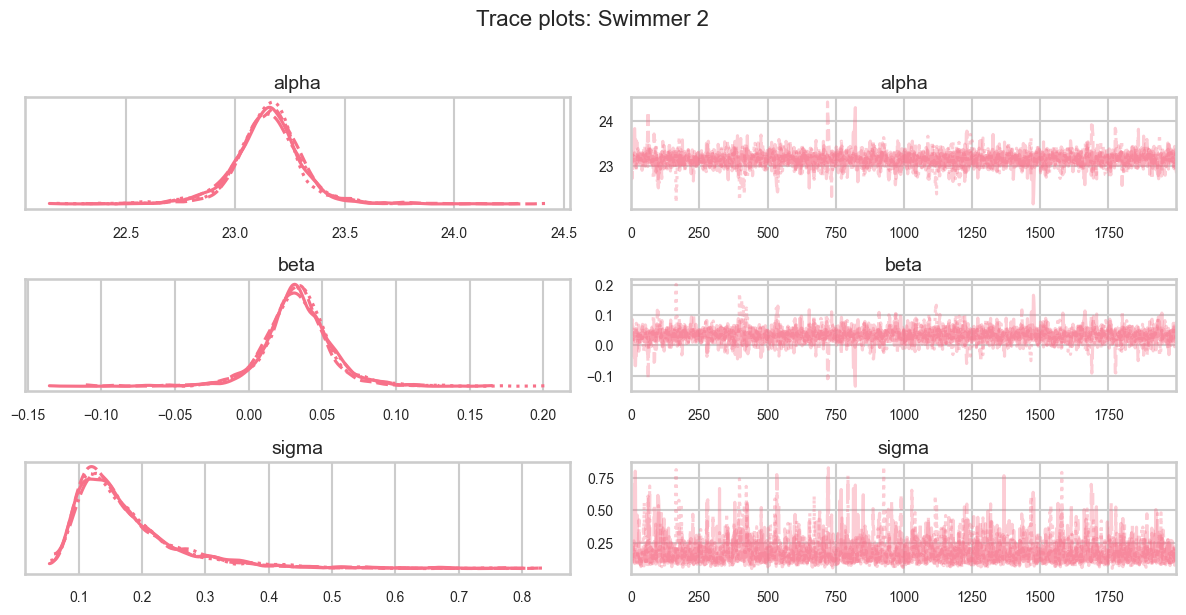

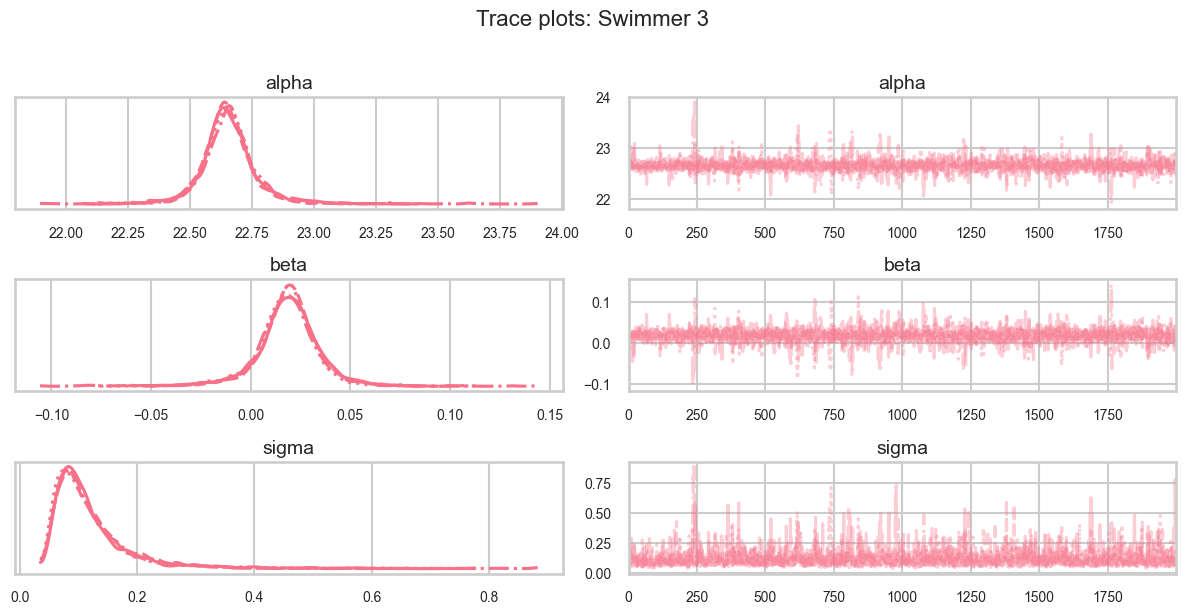

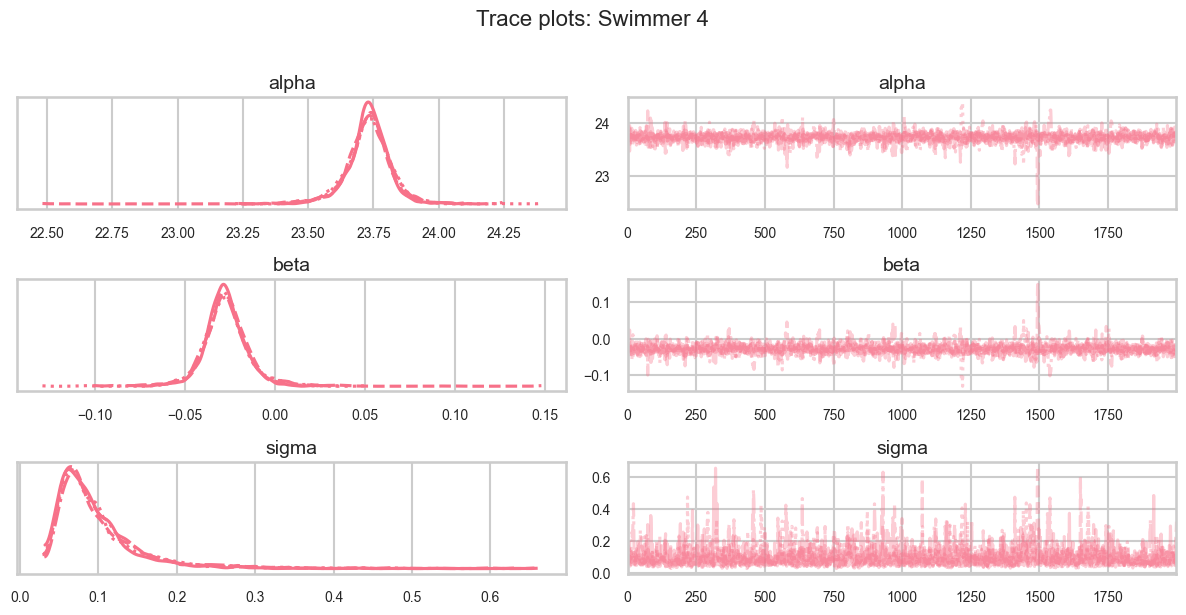

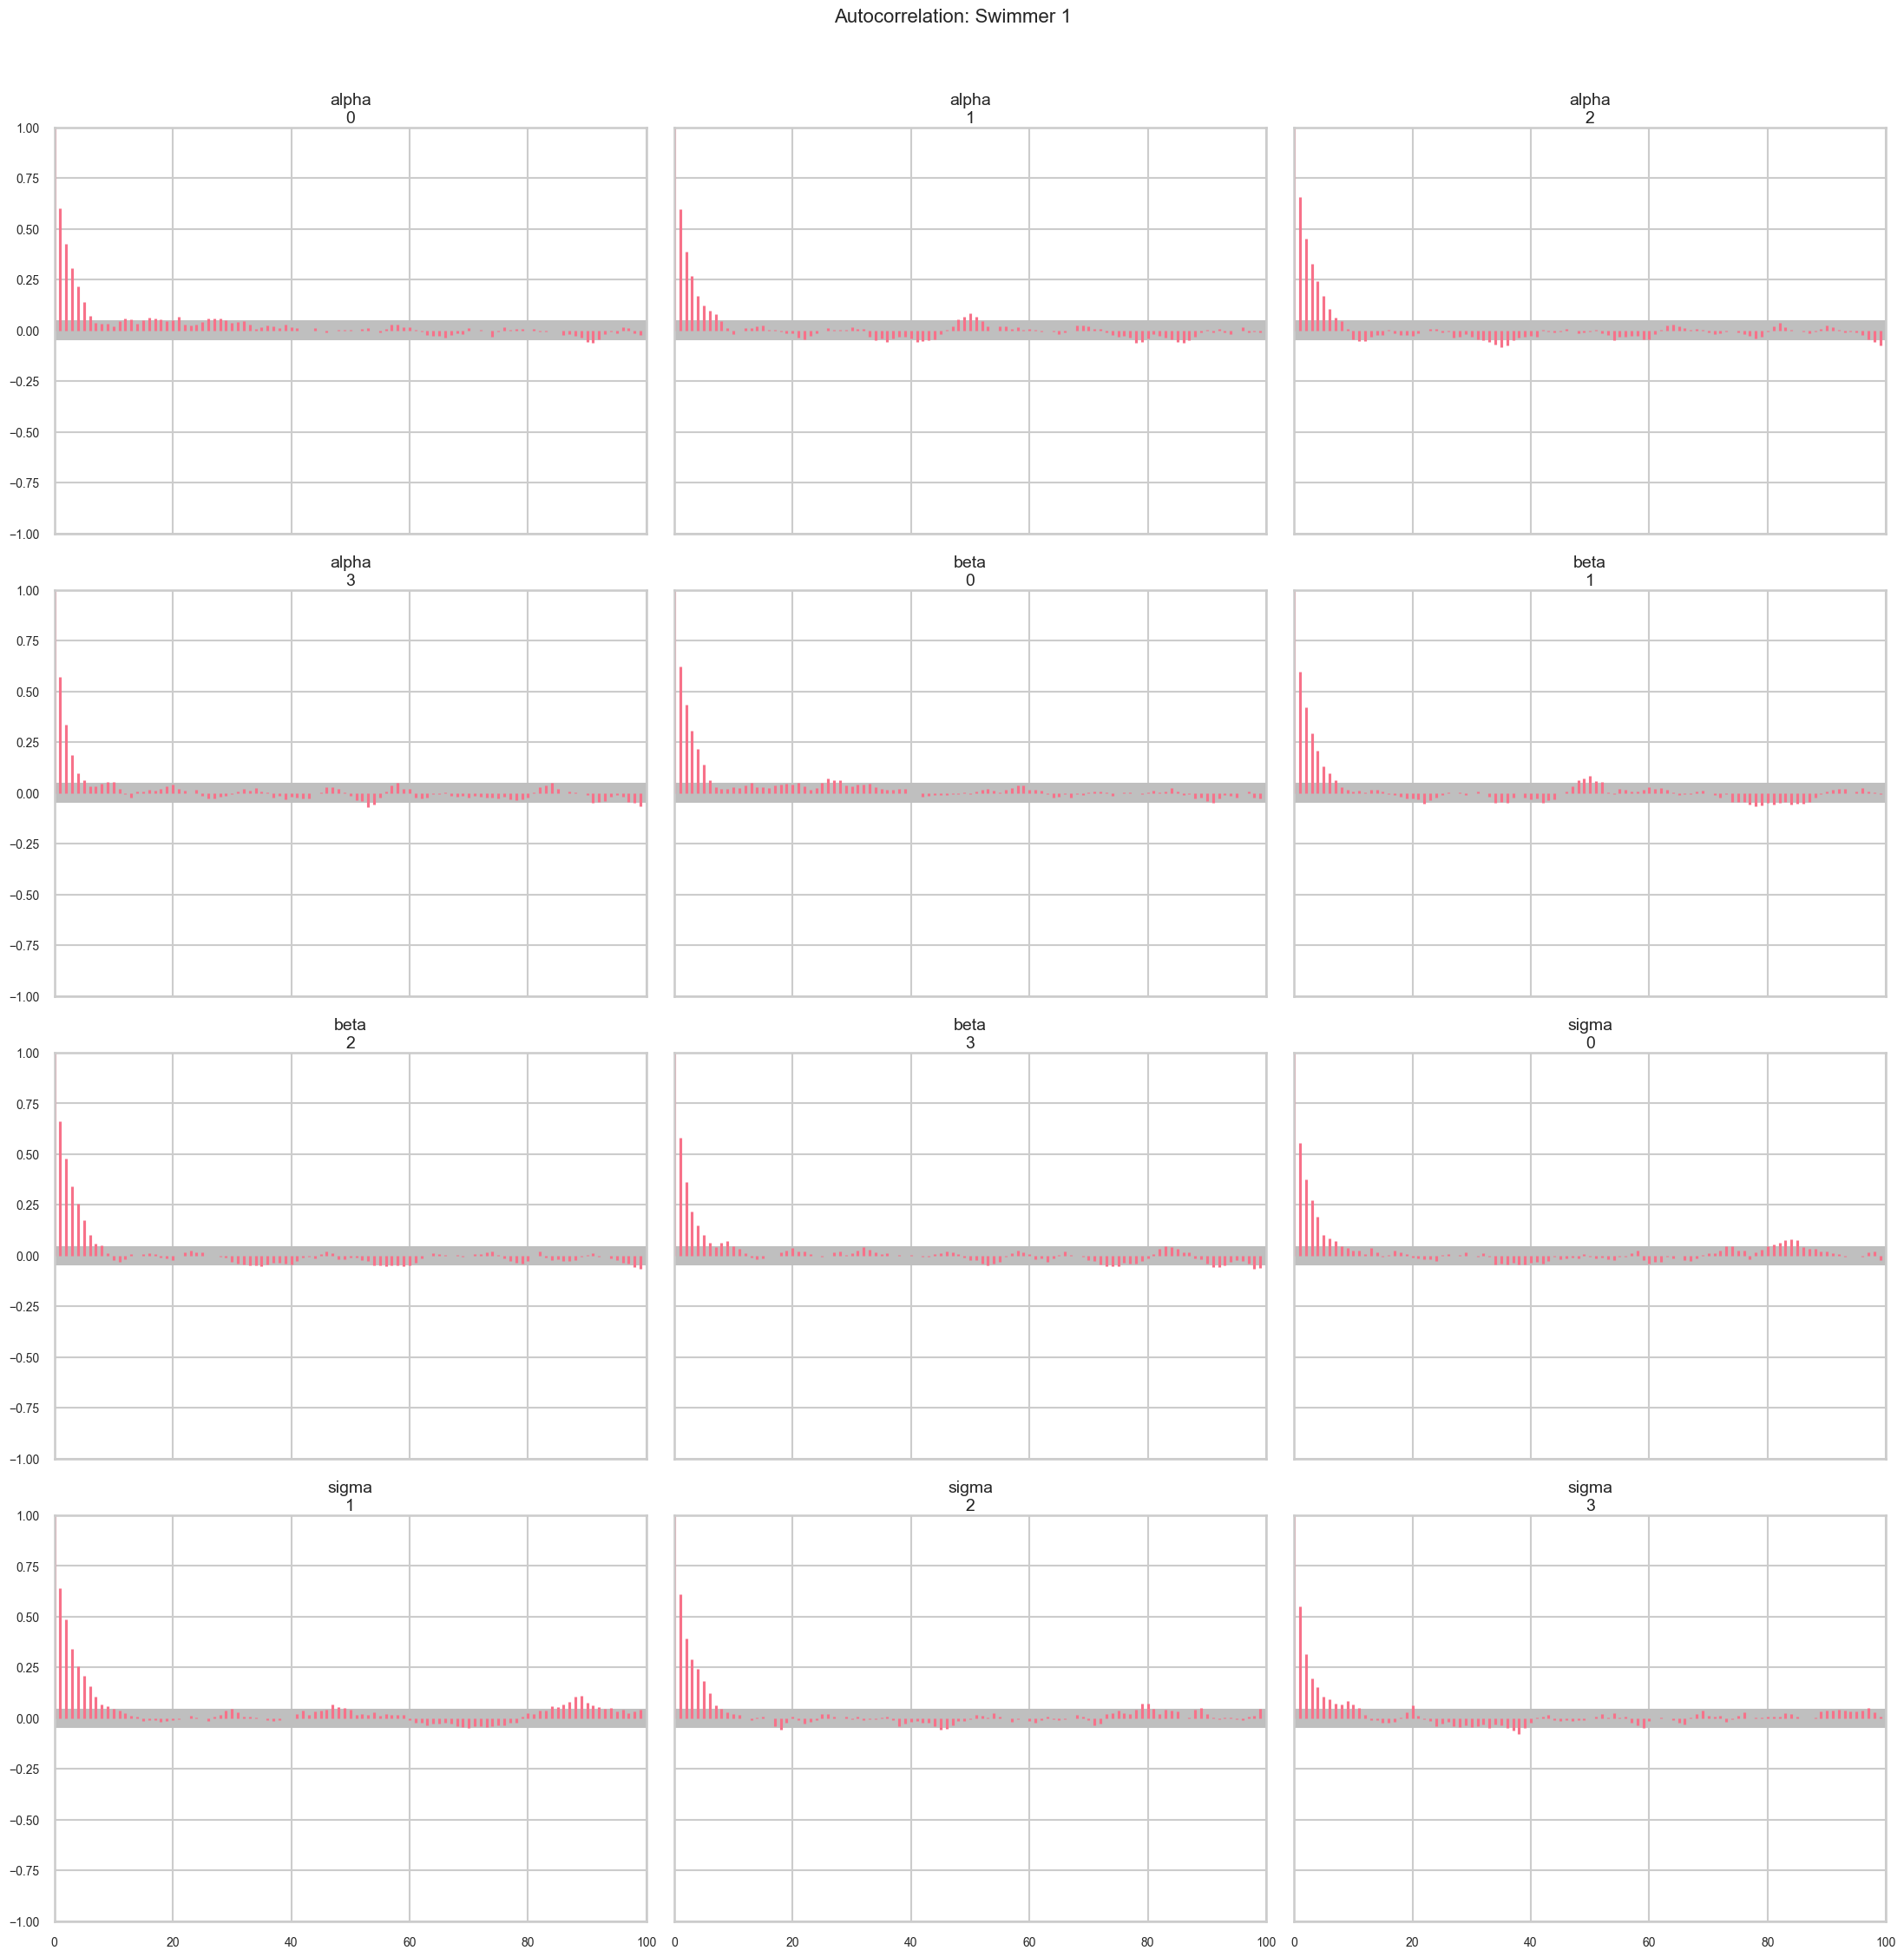

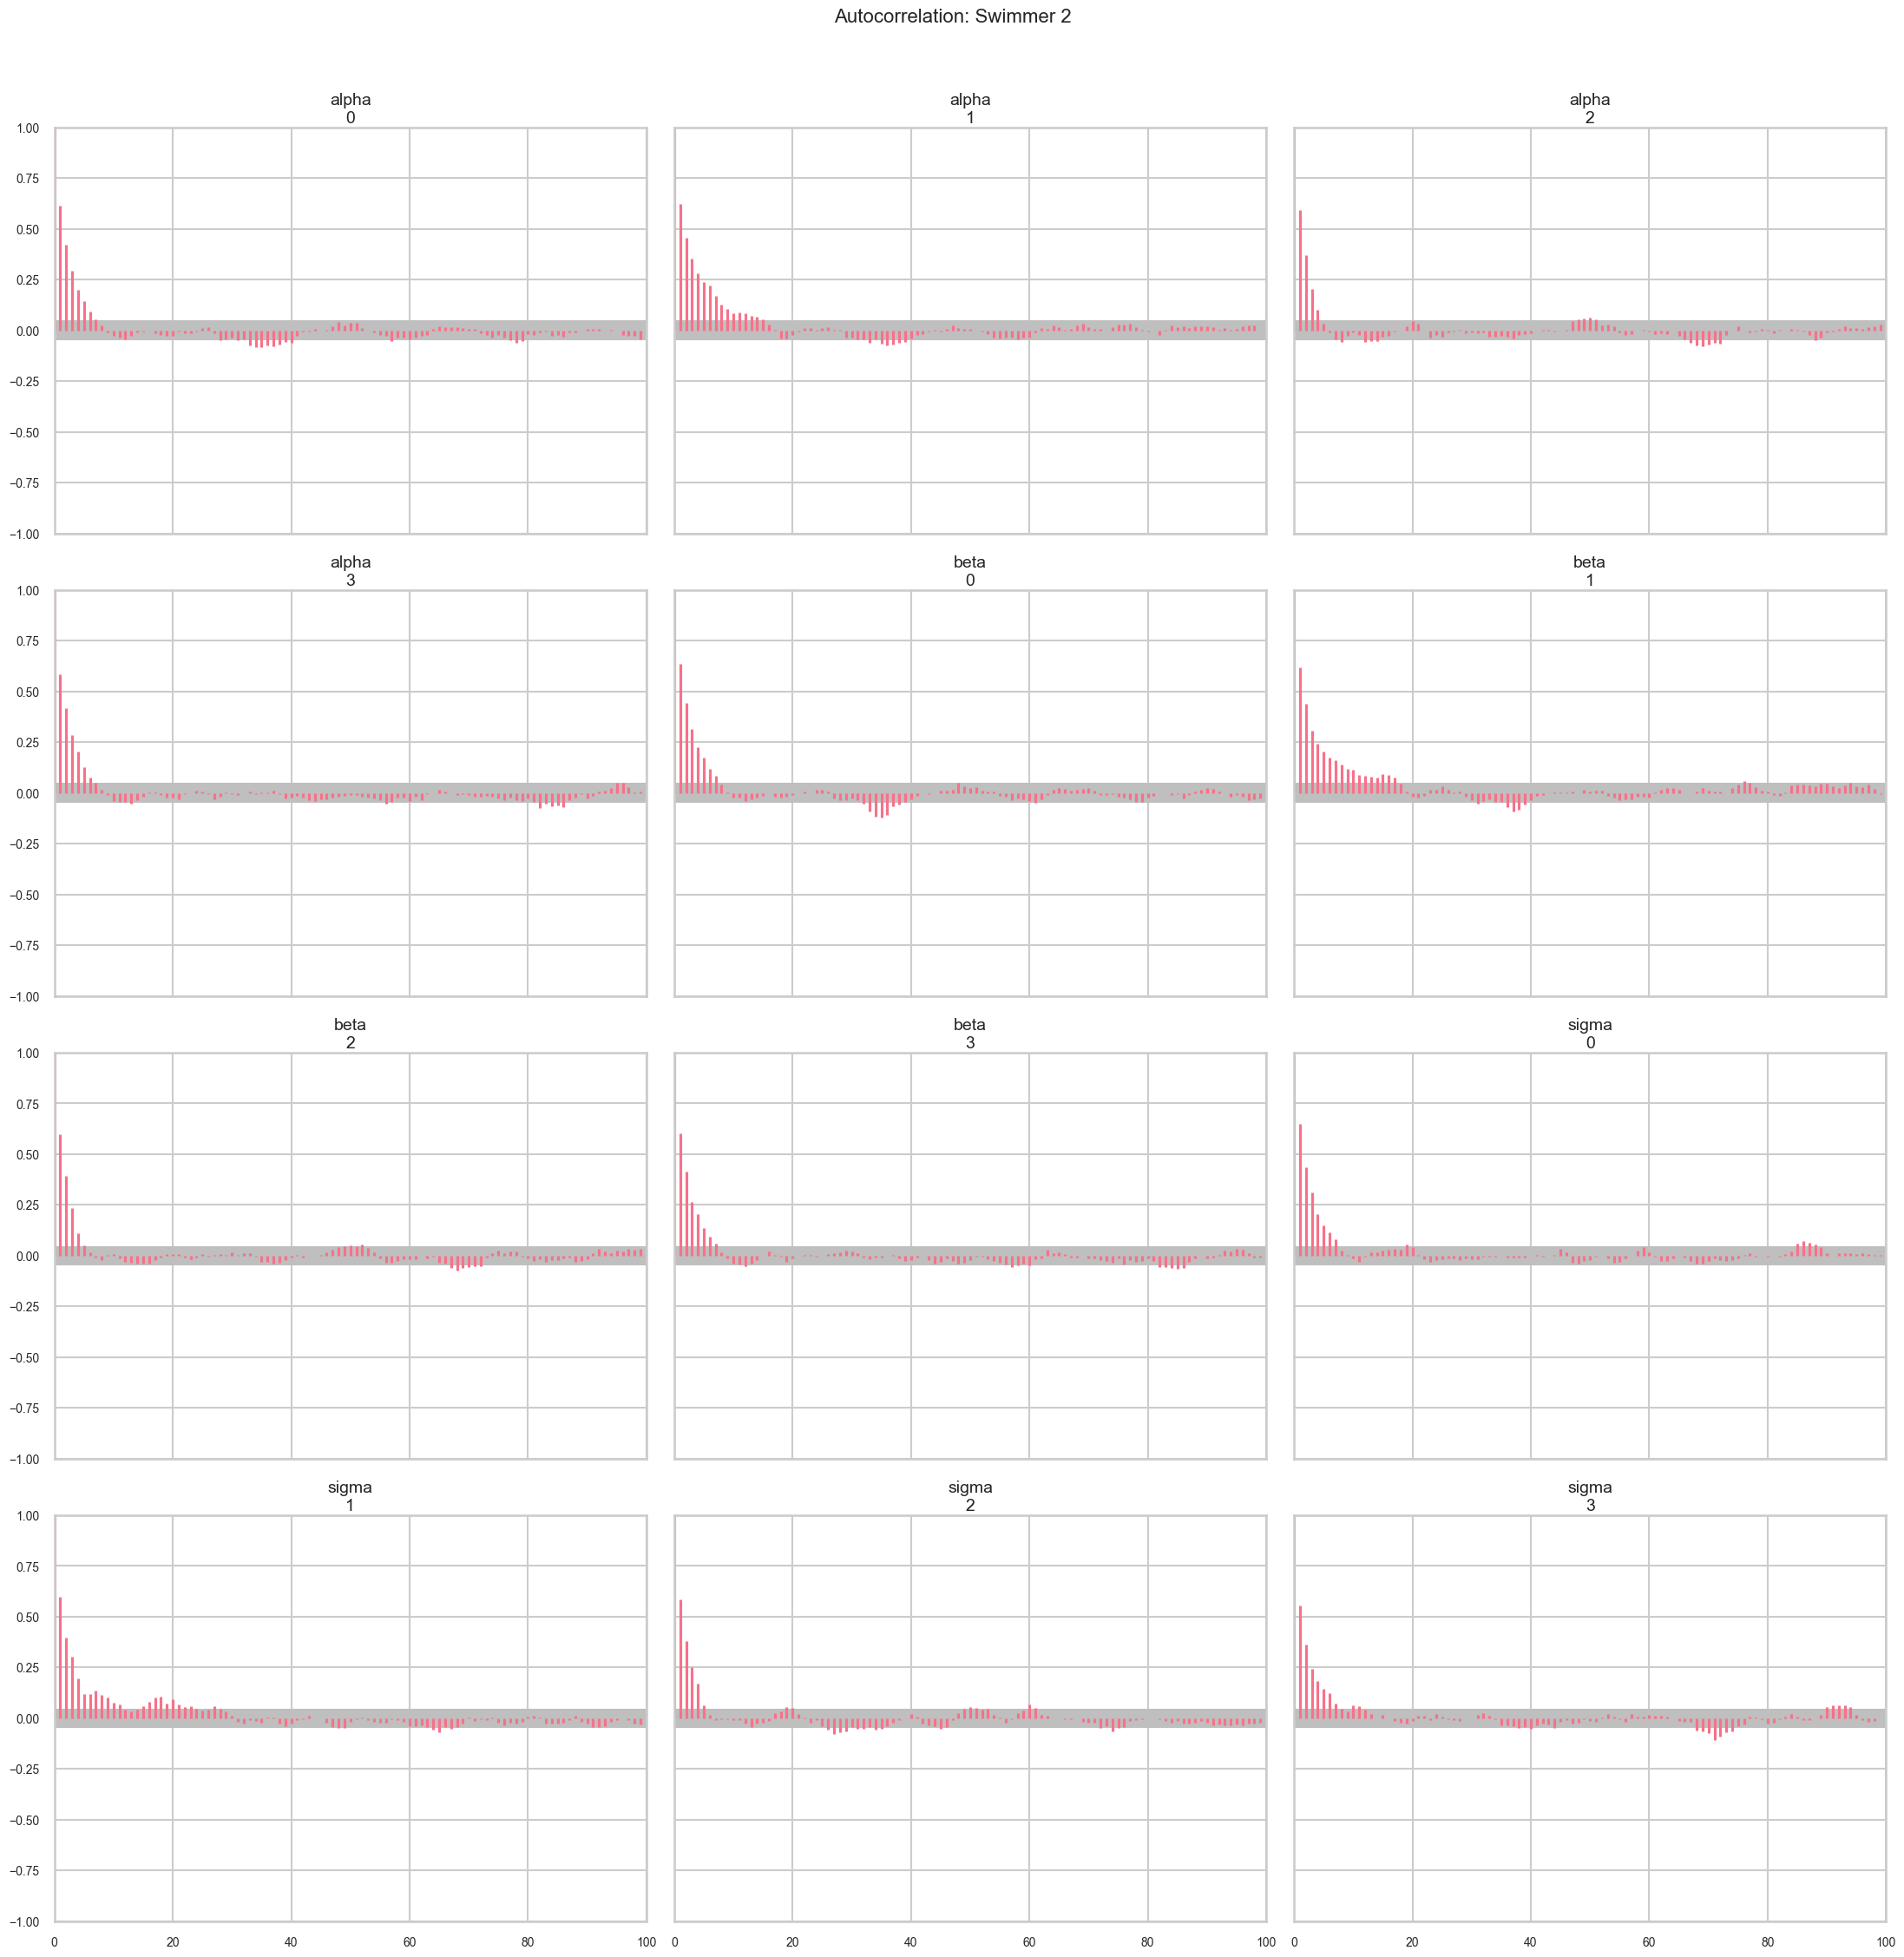

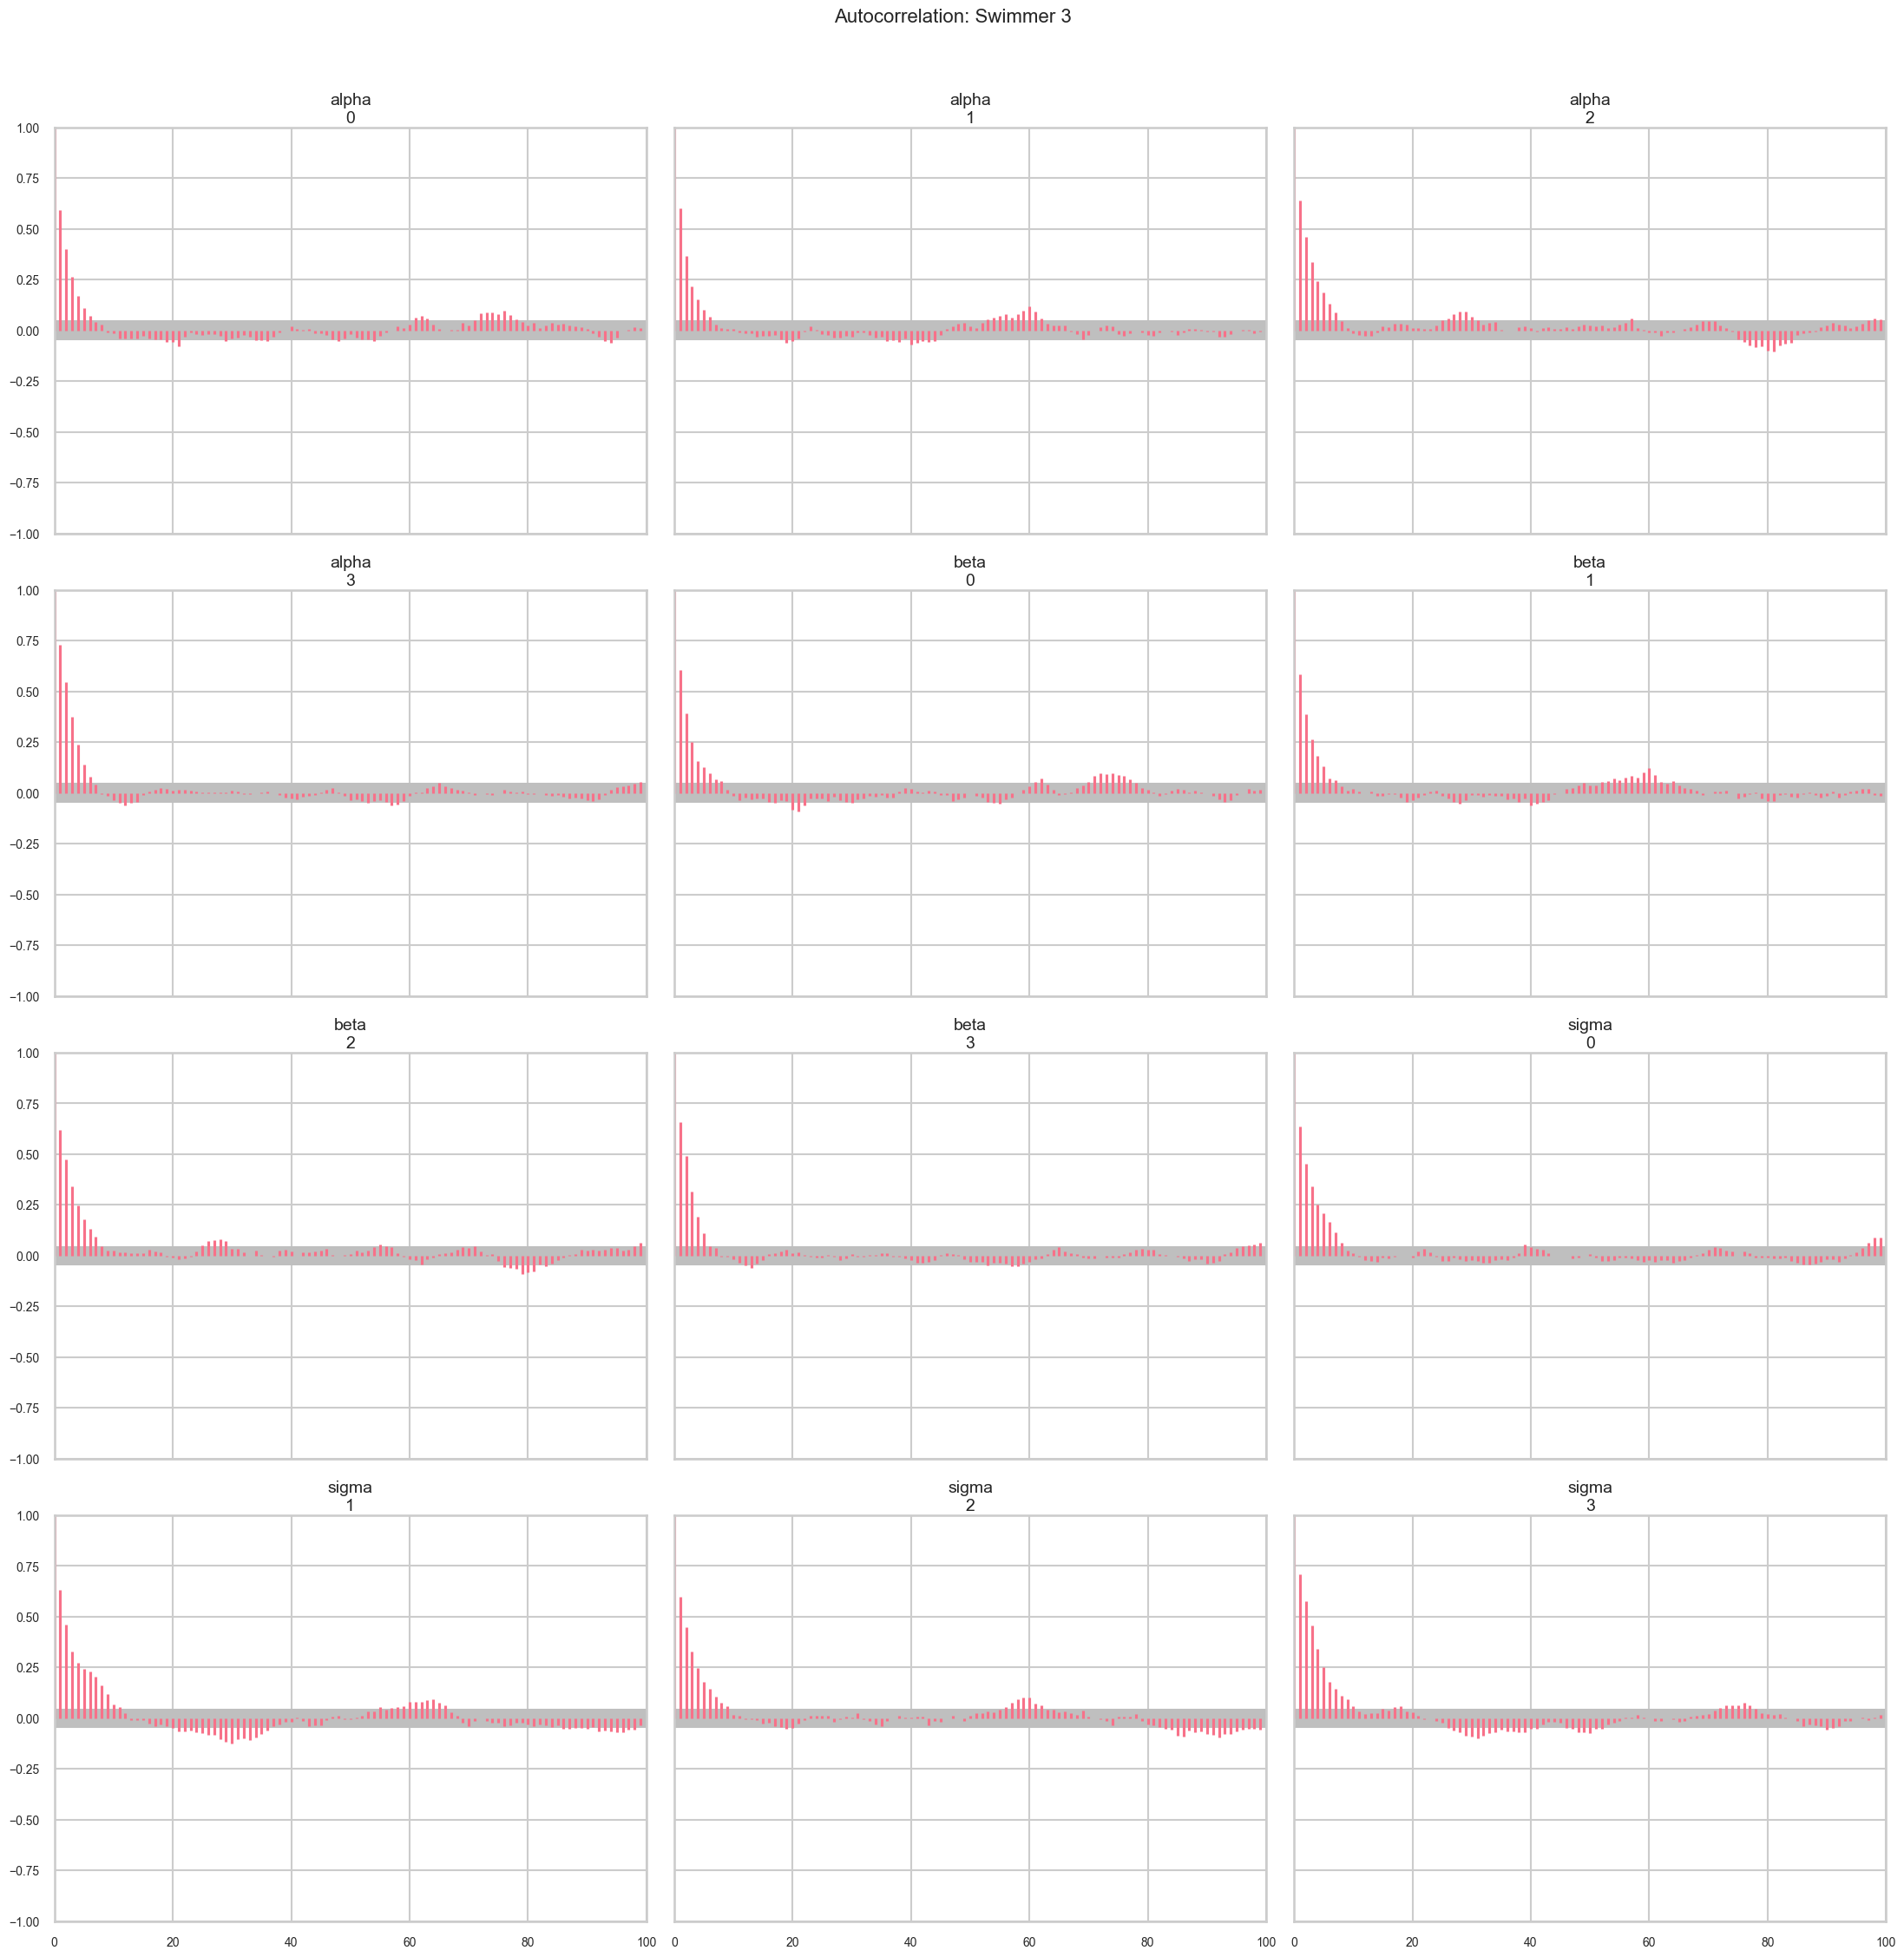

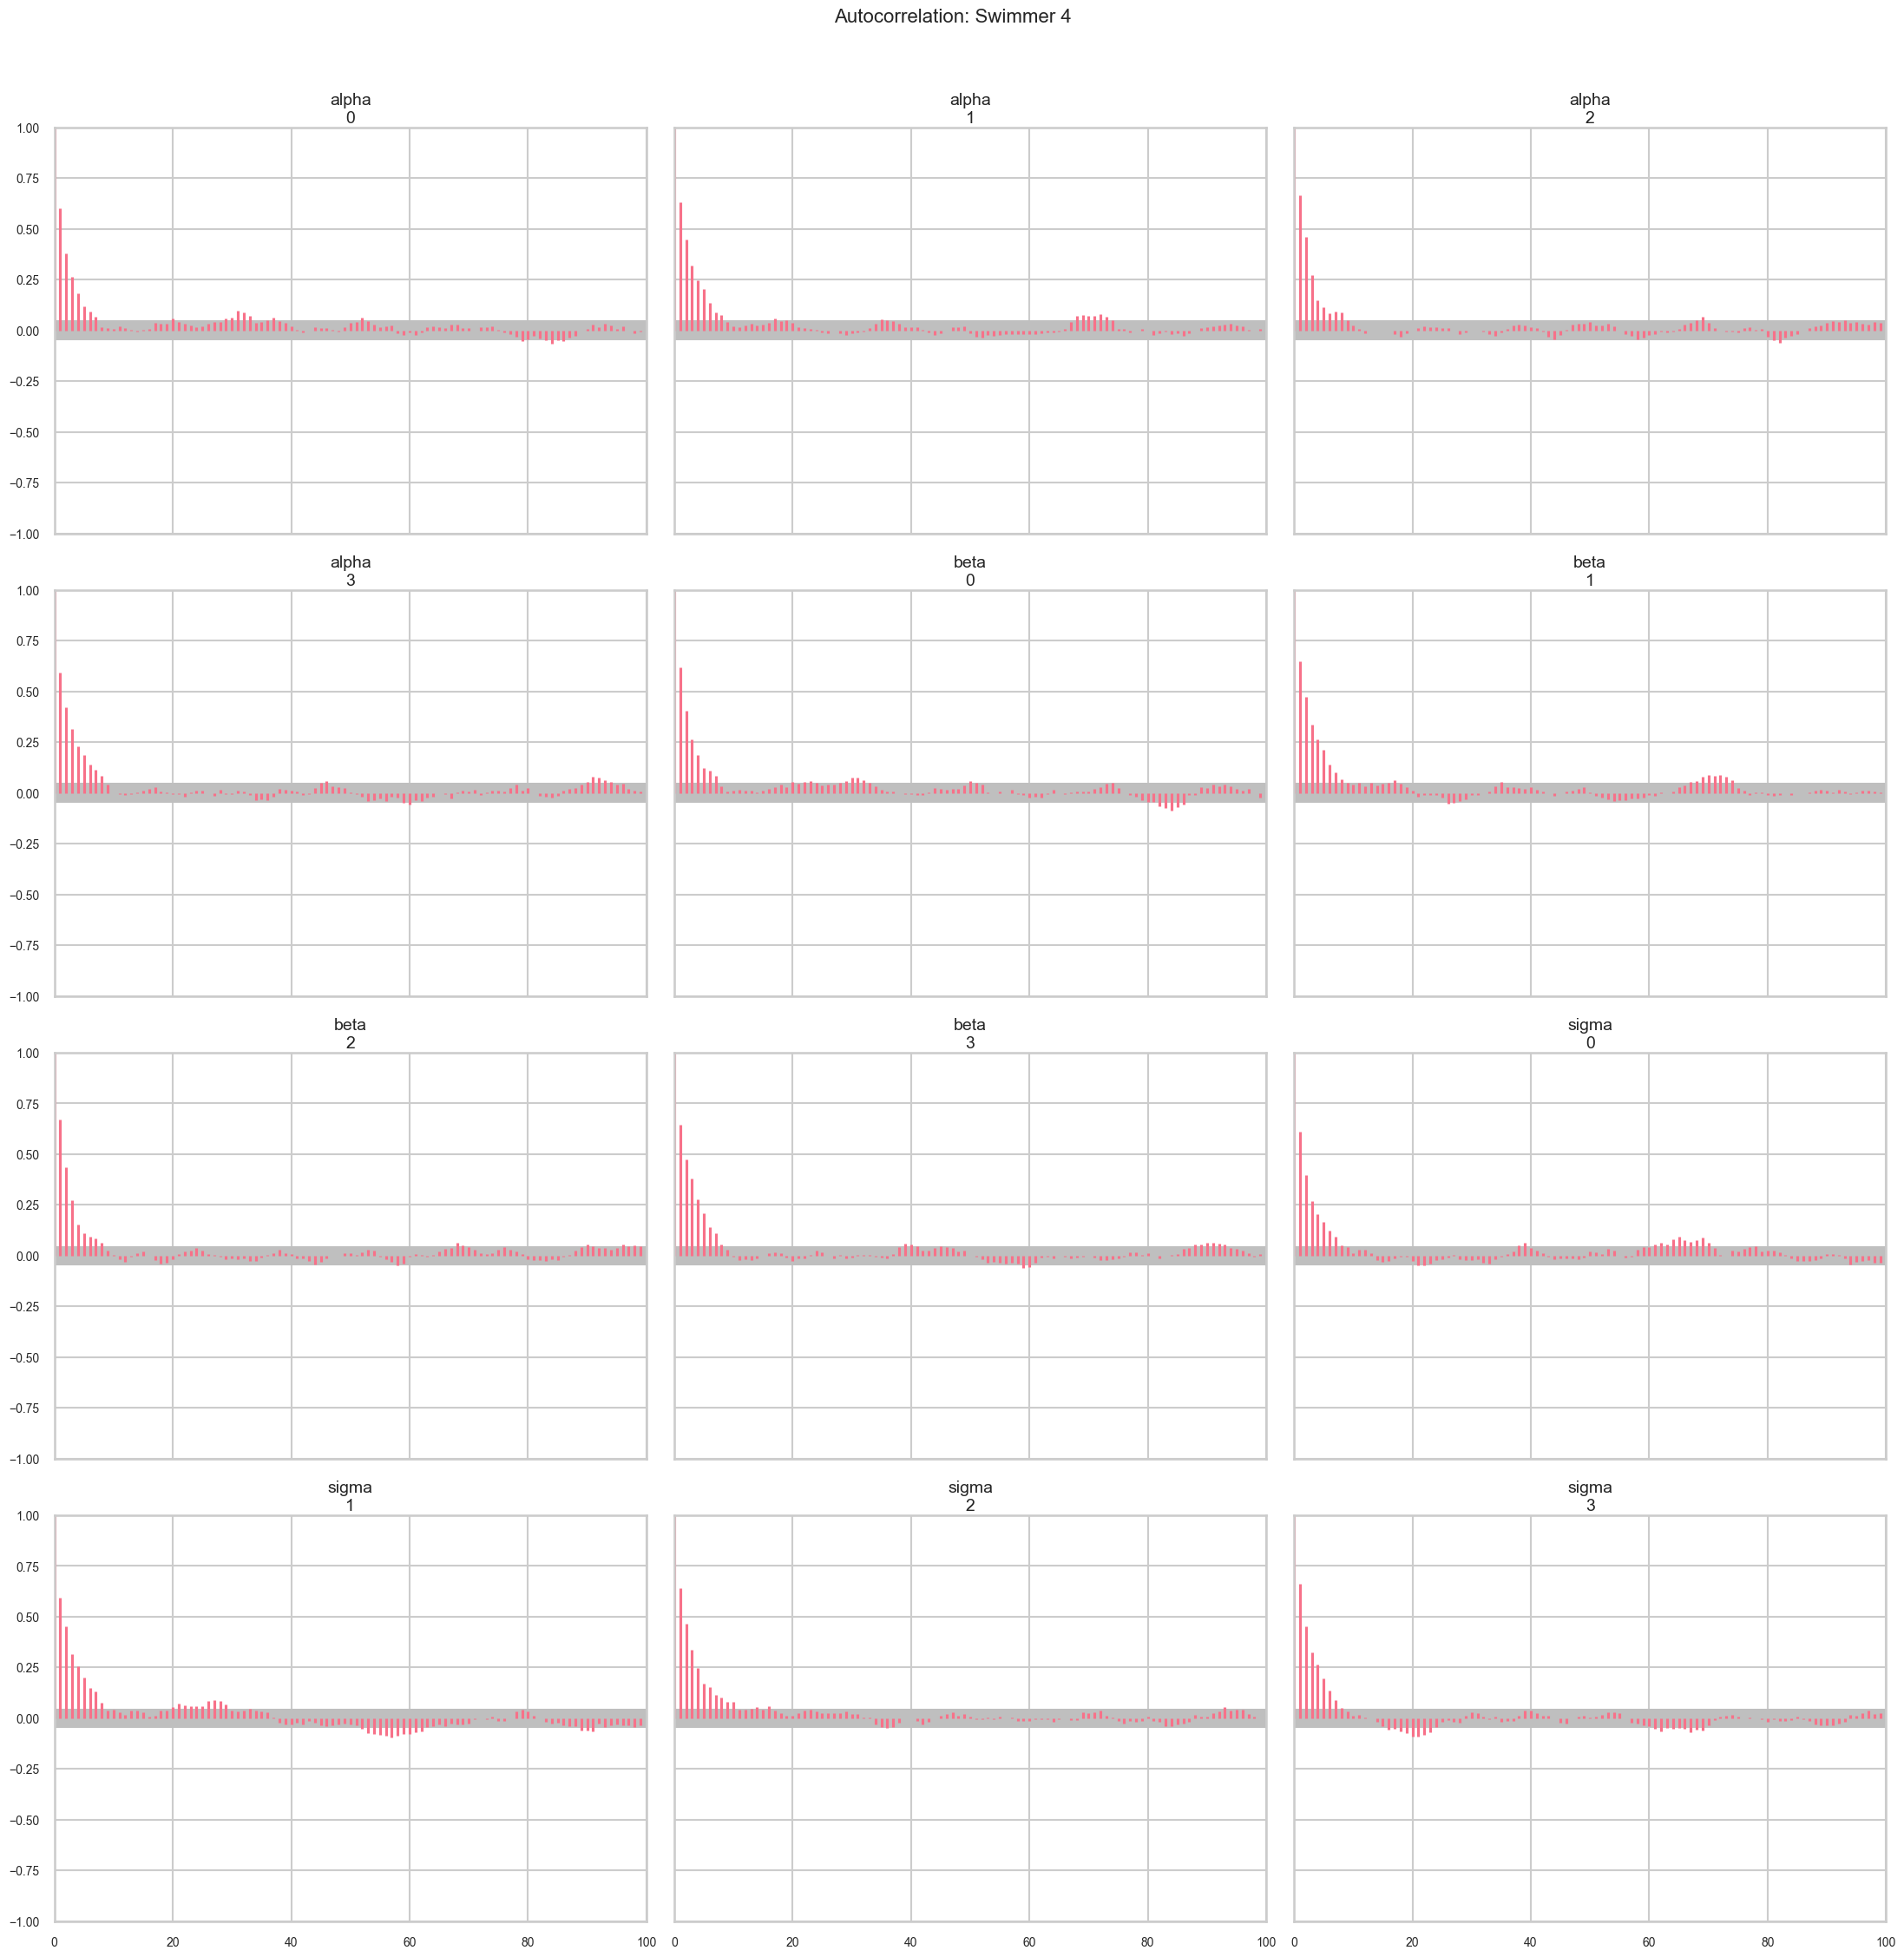

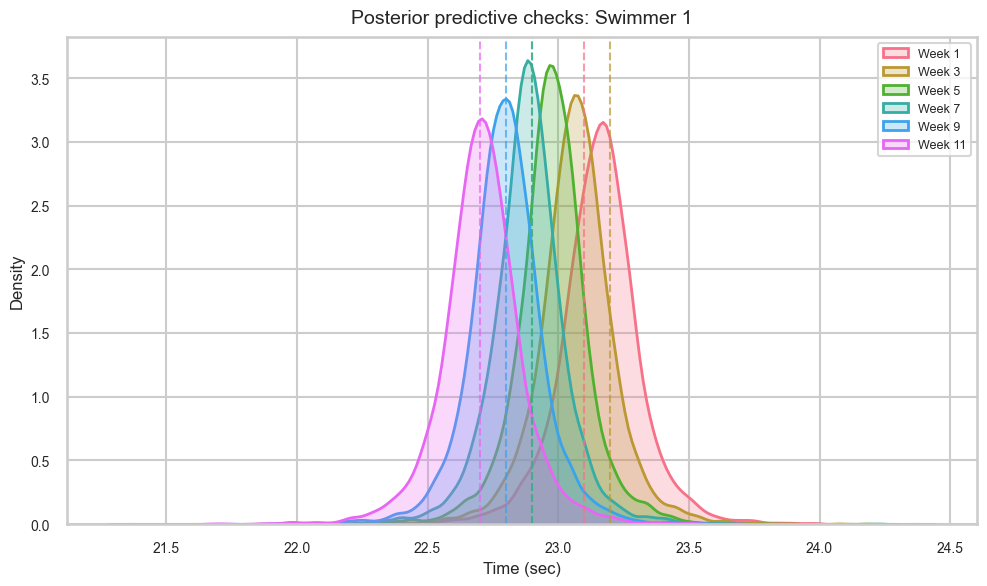

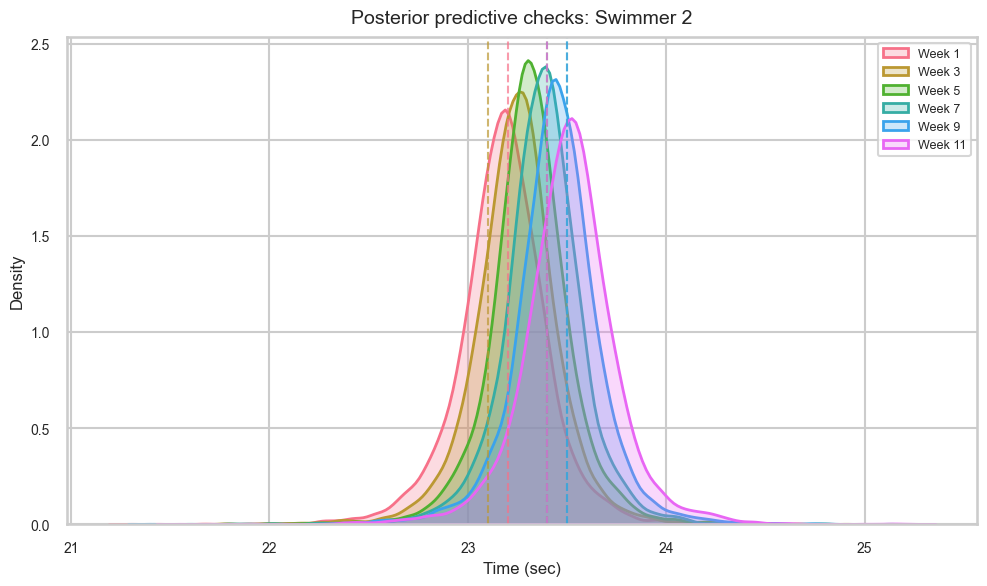

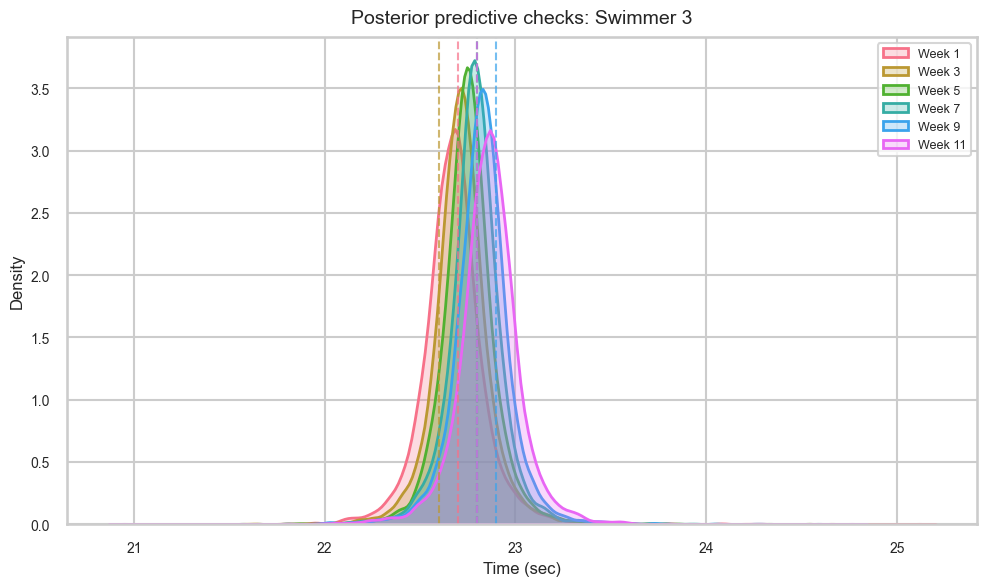

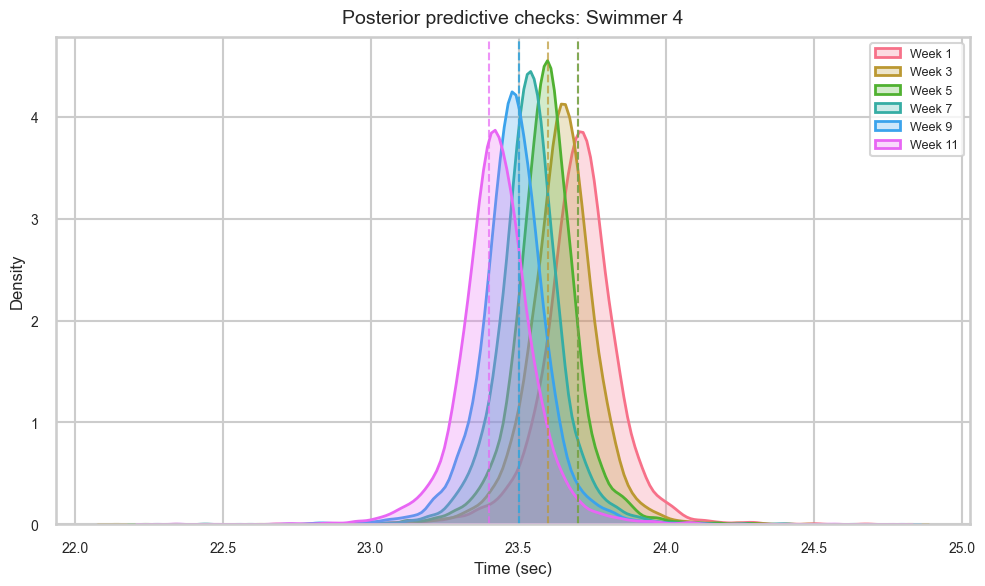

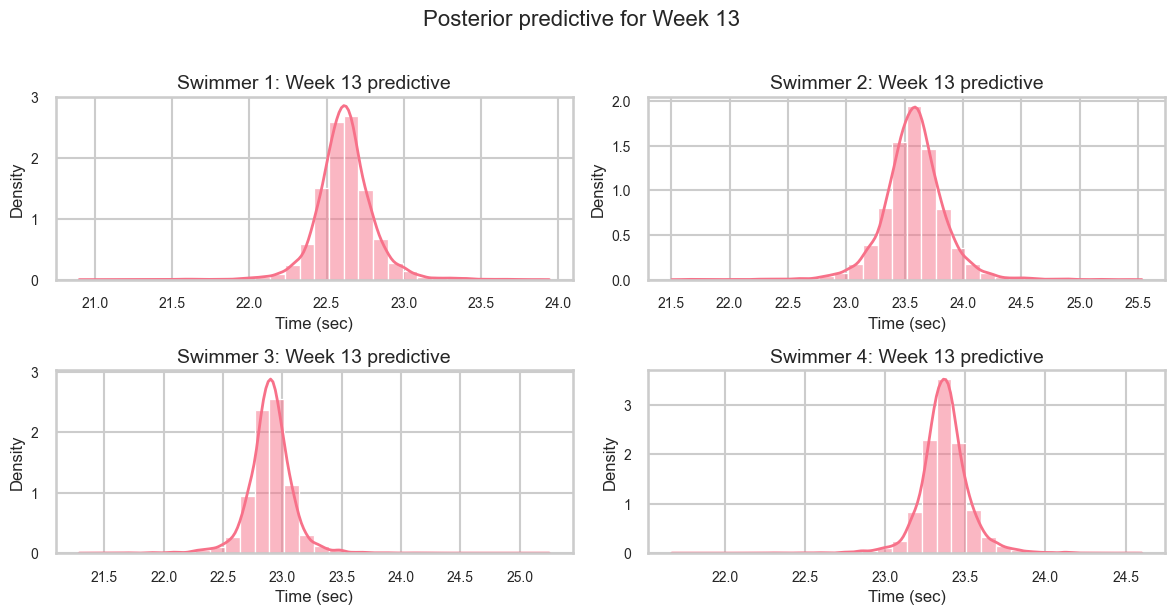

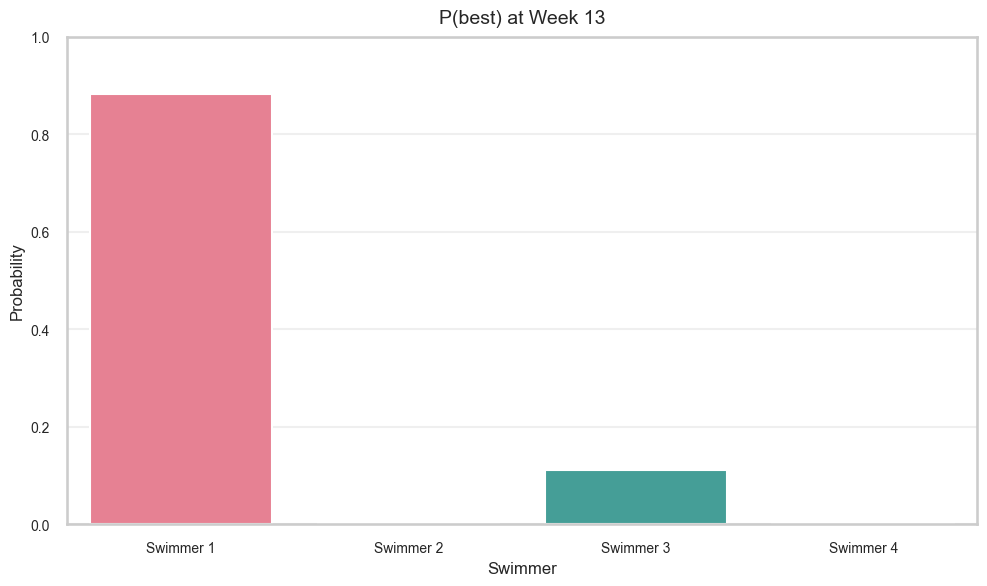

,Swimmer,Pred mean (sec),Pred sd (sec),Pred 95% CrI low,Pred 95% CrI high
0,Swimmer 1,22.618,0.183,22.267,22.996
1,Swimmer 2,23.577,0.265,23.047,24.101
2,Swimmer 3,22.897,0.187,22.512,23.268
3,Swimmer 4,23.371,0.152,23.074,23.692


Recommendation for the meet in two weeks: Swimmer 1


In [11]:
main()